In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
def preference_creation(family_size: int):
    if family_size == 1:
        preferences = [2,3]
    elif family_size == 2:
        preferences = [1,3,4]
    elif family_size == 3:
        preferences = [1,2,4]
    elif family_size == 4:
        preferences = [2,3,5]
    elif family_size == 5:
        preferences = [4,6]
    else:
        preferences = [5]
    
    output = [min(family_size, 6)] + random.sample(preferences, len(preferences))
    return output

def housing_vacancy(stock):
    
    # Probability weights for each housing type (reverse proportion to the key size)
    weights = [1 / key for key in stock]

    # Distribute 80 units randomly across types with weighted choice
    units_to_add = 80
    while units_to_add > 0:
        random_type = random.choices(list(stock.keys()), weights=weights)[0]
        add_count = random.randint(1, units_to_add)  # Random count to add

        # Increment the randomly chosen type by the add_count
        stock[random_type] += add_count

        units_to_add -= add_count  # Reduce the remaining units to add

    return stock


In [35]:
# import file
df = pd.read_csv("data/Eligible_Applicants.csv")

# filtering eligible applicants 
df = df[df['familysize'] != 0] # removing applicants with family size = 0
df = df[df['income'] != 0] # removing applicants with income = 0
df = df[df['race'] != 0]
df = df.drop(df.columns[0:1], axis = 1)
df = df[~(df['income'] > 14160 + (7710 * df['familysize']))]
df['waittime'] = 0
# df = df.loc[df.index.repeat(20)].reset_index(drop=True)


preferences = []
for index, row in df.iterrows():
    preferences.append(preference_creation(int(row['familysize'])))

df['preferences'] = preferences 

# saving original
safe = df
print(f"Total Number of Applicants: {len(df)}")

Total Number of Applicants: 3473


In [6]:
# housing unit stock
original_housing_stock = {
    1: 9820,
    2: 4349,
    3: 3107,
    4: 1788,
    5: 880,
    6: 569
}
print(f"Total Housing Stock: {sum(original_housing_stock.values())}")
# 1 in every 25 housing units available in the initial period
for key in original_housing_stock.keys():
    original_housing_stock[key] = original_housing_stock[key] // 25 

print(f"Total Housing Units Available: {sum(original_housing_stock.values())}")

Total Housing Stock: 20513
Total Housing Units Available: 817


In [5]:
# The output schema has enough space for 100 experiments
df_output = pd.read_csv("results/outputschema100.csv")


In [7]:
priorities = ['income', 'numchildren', 'numelderly', 'veteran', 'disability']

for experiment_no in range(10):
    count = 2
    for priority in priorities:
        # reset dataframe to 0 wait times and ranking = 0
        df = safe.sample(frac = 1)
        # df.sample(frac=1)
        # sort dataframe by priority system and save to waitlist
        if priority == 'income':
            waitlist = df.sort_values(by=priority, ascending=True)
        else:
            waitlist = df.sort_values(by=priority, ascending=False)

        # maximum 5 years, allocating 12, end when waitlist is empty
        period = 12*5 
        for _ in range(int(period)):
            # break when waitlist is empty
            if waitlist.shape[0] == 0:
                break
            # add x number of housing units per cycle
            housing_units = housing_vacancy(original_housing_stock)

            # for each applicant in the wait list
            for _, applicant in waitlist.iterrows():

                # identify the serial number
                serial_no = applicant['serialno']

                # for each choice in the preferences list
                for rank in applicant['preferences']:

                    # if that housing size/type is available
                    if housing_units[rank] > 0:

                        # set that housing choice to be their "ranking" (the preference they are matched with)
                        df.loc[df['serialno'] == serial_no, 'ranking'] = applicant['preferences'].index(rank) + 1

                        # reduce that available housing type by 1
                        housing_units[rank] -= 1

                        # remove them from the waitlist
                        waitlist = waitlist[waitlist['serialno'] != serial_no]
                        break
            
            # for all umatched, add 1 to waittime
            df.loc[df['ranking'] == 0, 'waittime'] += 1
        
        # Group by 'Race' and calculate the percentage of top choice within each group
        result = df.groupby('race').agg(
            Percentage=('ranking', lambda x: (x == 1).sum() / len(x) * 100),
            AverageWaitTime=('waittime', 'mean')
        ).reset_index()
        
        # Round 'Percentage' to 2 decimal points and format as percentage
        result['Percentage'] = result['Percentage'].map('{:.2f}%'.format)
        result.columns = ['Race', 'Percentage of Top Choice', 'Average Wait Time']

        top_choice = result['Percentage of Top Choice']
        avg_wait_time = result['Average Wait Time']

        n = len(top_choice)
        sum_tp = 0
        sum_wt = 0

        for i in range(8):
            for j in range(8):
                if i != j and float(top_choice[j][:-1]) != 0 and float(avg_wait_time[j]) != 0:   
                    ratio_tp = float(top_choice[i][:-1])/float(top_choice[j][:-1])
                    ratio_wt = float(avg_wait_time[i])/float(avg_wait_time[j])
                    sum_tp += ratio_tp
                    sum_wt += ratio_wt
                    
        sum_tp = sum_tp / (n**2 - n)
        sum_wt = sum_wt / (n**2 - n)

        top_choice_fairness = abs(1 - sum_tp)
        wait_time_fairness = abs(1 - sum_wt)

        idx_start = experiment_no * 8
        idx_end = (experiment_no * 8) + 8
        df_output.iloc[idx_start:idx_end, 0] = [experiment_no + 1] * 8 
        df_output.iloc[idx_start:idx_end, count] = result['Average Wait Time']
        df_output.iloc[idx_start:idx_end, count + 5] = result['Percentage of Top Choice']
        df_output.iloc[idx_start:idx_end, count + 10] = [wait_time_fairness] * 8
        df_output.iloc[idx_start:idx_end, count + 15] = [top_choice_fairness] * 8

        count += 1

print(df_output)  

df_output.to_csv(f"results/output/output_10_trials.csv", index = False)

     Experiment No  race_id   w_income  w_numchildren  w_elderly  w_veteran  \
0              1.0        1  12.422725      15.460420  15.872375  20.016694   
1              1.0        2  11.594505      13.305579  16.944213  20.595337   
2              1.0        3  11.166667       8.500000  19.833333  22.166667   
3              1.0        5  14.333333      17.555556  15.666667  18.777778   
4              1.0        6  13.855491      14.184971  14.924855  22.751445   
..             ...      ...        ...            ...        ...        ...   
803            NaN        5        NaN            NaN        NaN        NaN   
804            NaN        6        NaN            NaN        NaN        NaN   
805            NaN        7        NaN            NaN        NaN        NaN   
806            NaN        8        NaN            NaN        NaN        NaN   
807            NaN        9        NaN            NaN        NaN        NaN   

     w_disability t_income t_numchildren t_elderly 

[[13.81583198707593, 16.961766289714593, 18.28540656973613, 18.940226171243943, 19.399569197630587, 19.651050080775445, 20.016693591814757, 20.193322563274094, 20.25094238018309, 20.716747442110933], [14.506244796003331, 17.547044129891756, 18.503746877602, 19.64612822647793, 19.8451290591174, 20.50541215653622, 20.59533721898418, 20.65029142381349, 20.90091590341382, 21.387177352206496], [15.333333333333334, 15.5, 16.333333333333332, 19.83333333333333, 20.5, 21.33333333333333, 22.166666666666668, 29.0, 29.666666666666668, 29.83333333333333], [13.11111111111111, 13.666666666666666, 15.666666666666666, 16.444444444444443, 18.55555555555556, 18.77777777777778, 19.11111111111111, 22.11111111111111, 22.77777777777778, 24.33333333333333], [14.664739884393065, 16.77456647398844, 19.78034682080925, 20.277456647398843, 20.45664739884393, 21.54335260115607, 21.95953757225433, 22.38150289017341, 22.751445086705203, 23.104046242774565], [3.5, 5.5, 9.5, 12.5, 13.0, 20.5, 20.5, 22.0, 31.0, 35.0], [

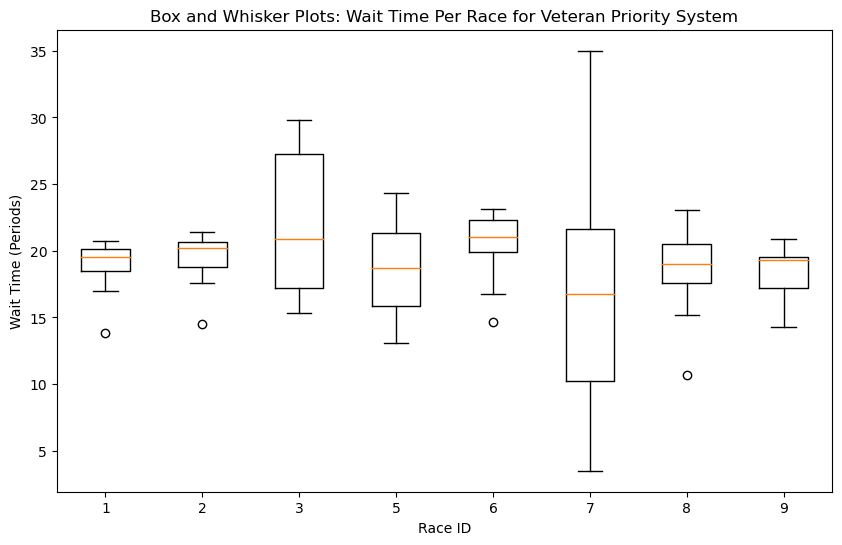

In [17]:
import matplotlib.pyplot as plt


df_all = pd.read_csv('results/output/output_10_trials.csv')

# Sort the DataFrame by 'Sort_Column'
df_all_sorted = df_all.sort_values('w_veteran')
df_all_sorted = df_all_sorted.reindex(sorted(df_all_sorted.columns), axis=1)

# Create a list to store data for each category
category_data = [df_all_sorted[df_all_sorted['race_id'] == category]['w_veteran'].tolist() for category in sorted(df_all_sorted['race_id'].unique())]
category_data_float = []
for vector in category_data:
    vector = [float(data) for data in vector]
    category_data_float.append(vector)
    
print(category_data_float)
# Plot multiple box and whisker plots
plt.figure(figsize=(10, 6))
plt.boxplot(category_data_float, labels=sorted(df_all_sorted['race_id'].unique()))

# Add labels and title
plt.xlabel('Race ID')
plt.ylabel('Wait Time (Periods)')
plt.title('Box and Whisker Plots: Wait Time Per Race for Veteran Priority System')

# Show the plot
plt.show()

[0.1669500973905123, 0.13706883214956103, 0.1772963892812209, 0.13092615061663648, 0.12013282204318945]


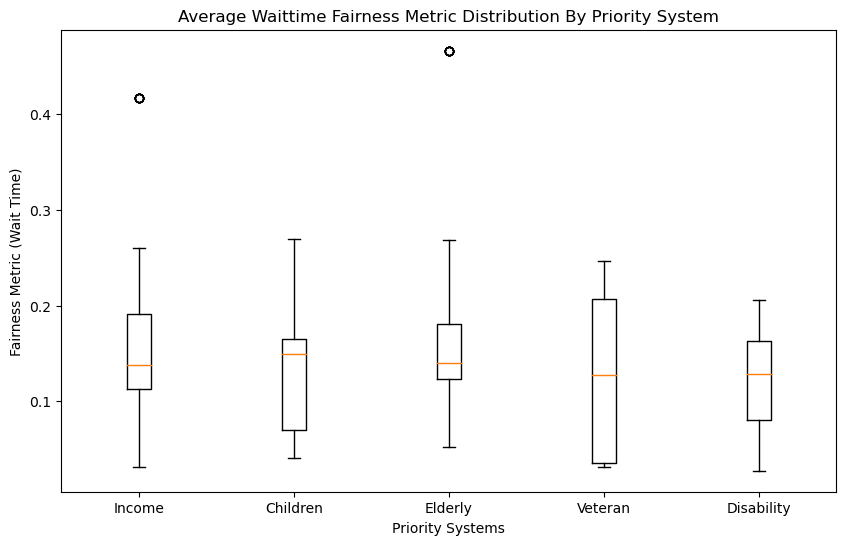

In [34]:
plt.figure(figsize=(10, 6))

df_all = pd.read_csv('results/output/output_10_trials.csv')

custom_labels = ['Income', 'Children', 'Elderly', 'Veteran', 'Disability']
avg_fairness_per_group = []

# Iterate through each column and create a box plot
for i, column in enumerate(['tf_income', 'tf_numchildren', 'tf_elderly', 'tf_veteran', 'tf_disability']):
    plt.boxplot(df_all[column], positions=[i+1], labels=[custom_labels[i]])
    avg_fairness_per_group.append(np.mean(df_all[column]))

print(avg_fairness_per_group)
# Customize labels and title
plt.xlabel('Priority Systems')
plt.ylabel('Fairness Metric (Wait Time)')
plt.title('Average Waittime Fairness Metric Distribution By Priority System')

# Show the plots
plt.show()

In [69]:
# Initialize an empty DataFrame to store the combined data
experiment_all = pd.DataFrame()

# Loop through the experiment files from 1 to 10
for i in range(1, 11):
    file_path = f'results/dataframes/experiment_{i}.csv'
    
    # Read the current experiment file
    current_data = pd.read_csv(file_path)
    
    # Concatenate the current experiment data to the combined data
    experiment_all = pd.concat([experiment_all, current_data], ignore_index=True)

# Save the combined data to a new CSV file

experiment_all.to_csv('results/dataframes/experiment_all.csv', index=False)

42.221999999999994


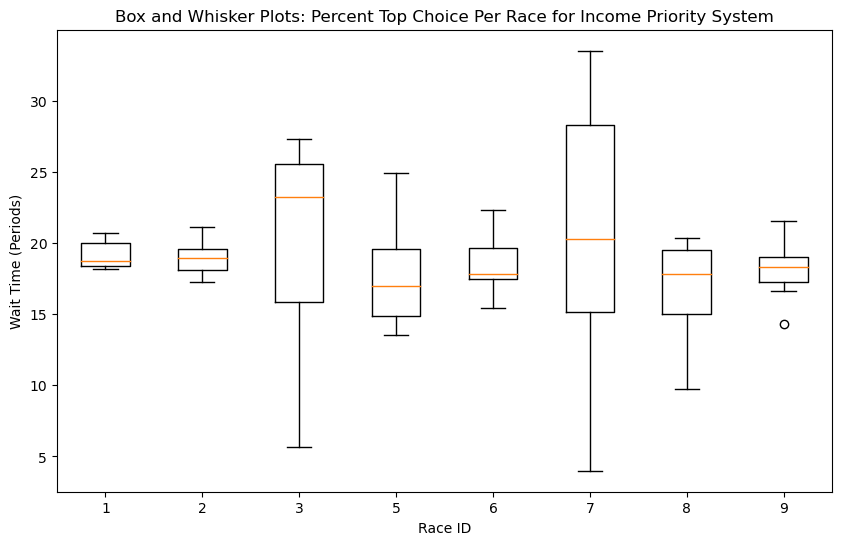

36.888999999999996


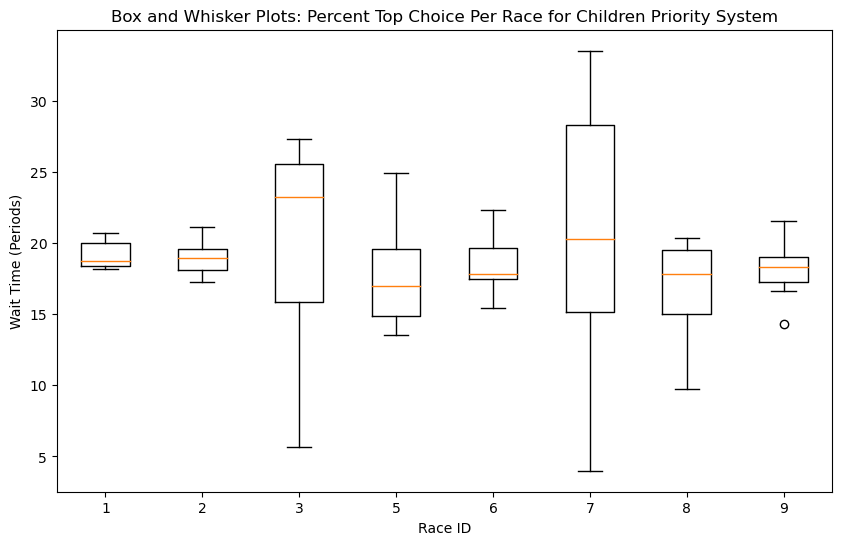

46.777


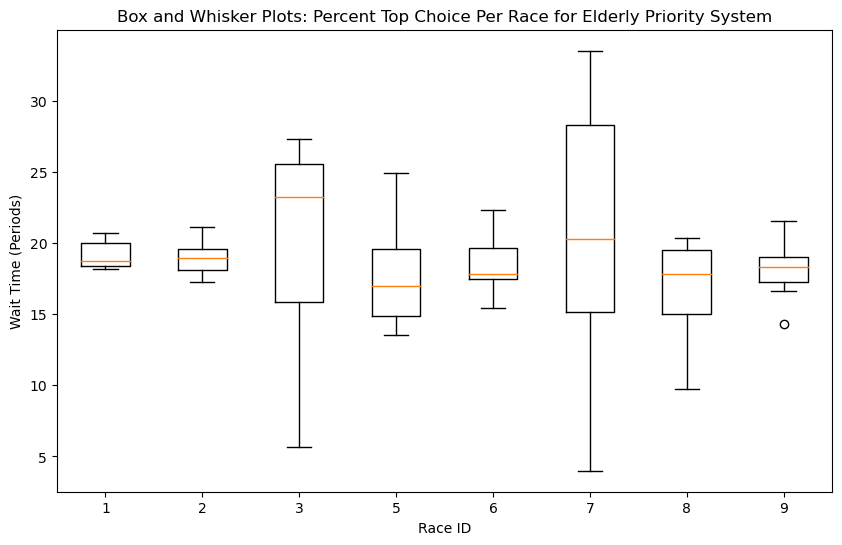

46.444


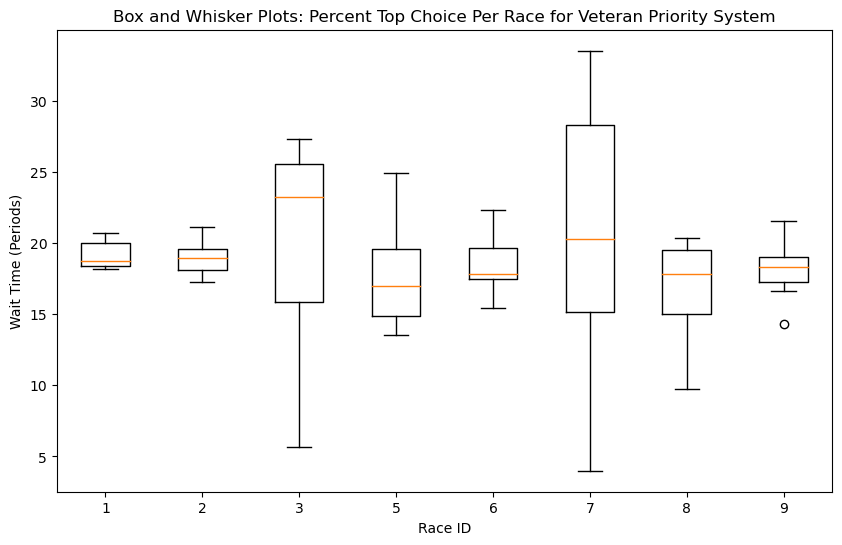

45.66600000000001


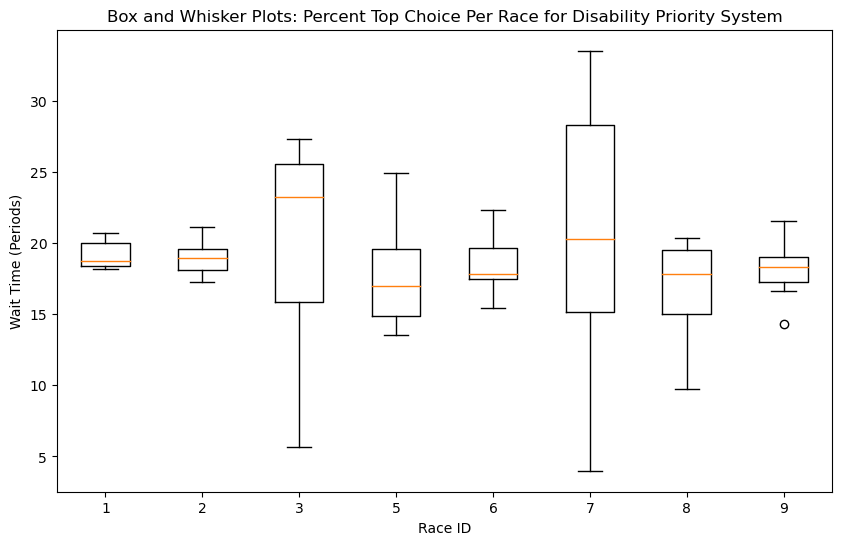

In [44]:
import matplotlib.pyplot as plt


df_all = pd.read_csv('results/output/output_10_trials.csv')
custom_labels = ['Income', 'Children', 'Elderly', 'Veteran', 'Disability']
columns = ['t_income', 't_numchildren', 't_elderly', 't_veteran', 't_disability']


for i in range(len(columns)):
    # Sort the DataFrame by 'Sort_Column'
    df_all_sorted = df_all.sort_values(columns[i])
    df_all_sorted = df_all_sorted.reindex(sorted(df_all_sorted.columns), axis=1)

    # Create a list to store data for each category
    category_data = [df_all_sorted[df_all_sorted['race_id'] == category][columns[i]].tolist() for category in sorted(df_all_sorted['race_id'].unique())]
    mean_per_group = []
    for vector in category_data:
        vector = [float(data[:-1]) for data in vector]
        mean_per_group.append(np.mean(vector))
    
        
    print(np.mean(vector))
    # Plot multiple box and whisker plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(category_data_float, labels=sorted(df_all_sorted['race_id'].unique()))

    # Add labels and title
    plt.xlabel('Race ID')
    plt.ylabel('Wait Time (Periods)')
    plt.title(f'Box and Whisker Plots: Percent Top Choice Per Race for {custom_labels[i]} Priority System')

    # Show the plot
    plt.show()